# Test Transquest

In [1]:
from metrics import pearsonr_metric, mae_metric, rmse_metric
import pandas as pd
tquest_df = pd.read_csv("output_quest.csv")

In [2]:
tquest_df.head(3)

,Unnamed: 0,src,mt,pe,avg_len,mtr_score,ref_len,nst_score,nst_blc_score,final_score,transquest
0,0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,José Ortega y Gasset besuchte Husserl in Freib...,12,0.794492,12,3.116148,4.331309,0.808846,0.744348
1,1,"however , a disappointing ninth in China meant...",eine enttäuschende Neunte in China bedeutete j...,ein enttäuschender neunter Platz in China bede...,20,0.903902,20,3.608044,4.174426,0.890099,0.733772
2,2,"in his diary , Chase wrote that the release of...","in seinem Tagebuch , Chase schrieb , dass die ...","in seinem Tagebuch schrieb Chase , dass die Fr...",23,0.782187,23,3.736856,4.120092,0.790553,0.702712


In [3]:
print("transquest results")
print(mae_metric(tquest_df["final_score"],tquest_df["transquest"]))
print(rmse_metric(tquest_df["final_score"],tquest_df["transquest"]))
print(pearsonr_metric(tquest_df["final_score"],tquest_df["transquest"]))

transquest results
Mean absolute error: 0.141
Root mean squared error: 0.176
Pearson correlation coefficient: 0.292


In [4]:
print("transquest results vs mtr_score")
print(mae_metric(tquest_df["mtr_score"],tquest_df["transquest"]))
print(rmse_metric(tquest_df["mtr_score"],tquest_df["transquest"]))
print(pearsonr_metric(tquest_df["mtr_score"],tquest_df["transquest"]))

transquest results vs mtr_score
Mean absolute error: 0.144
Root mean squared error: 0.180
Pearson correlation coefficient: 0.290


In [5]:
print("transquest results vs nist ")
print(mae_metric(tquest_df["nst_score"]/10,tquest_df["transquest"]))
print(rmse_metric(tquest_df["nst_score"]/10,tquest_df["transquest"]))
print(pearsonr_metric(tquest_df["nst_score"]/10,tquest_df["transquest"]))

transquest results vs nist 
Mean absolute error: 0.433
Root mean squared error: 0.439
Pearson correlation coefficient: 0.171


In [6]:
import pandas as pd 

pred = pd.read_csv("./output/predicted_quest++.csv")
pred.head(3)

,official,quest++
0,5.0,3.548300
1,2.5,3.055105
2,4.5,3.562239


In [7]:
from metrics import pearsonr_metric, mae_metric, rmse_metric
print("quest++ results")
print(mae_metric(pred["official"],pred["quest++"]))
print(rmse_metric(pred["official"],pred["quest++"]))
print(pearsonr_metric(pred["official"],pred["quest++"]))

quest++ results
Mean absolute error: 0.751
Root mean squared error: 0.898
Pearson correlation coefficient: 0.491


### transquest results
- Mean absolute error: 0.141
- Root mean squared error: 0.176
- Pearson correlation coefficient: 0.292

### quest++ results
- Mean absolute error: 0.751
- Root mean squared error: 0.898
- Pearson correlation coefficient: 0.491



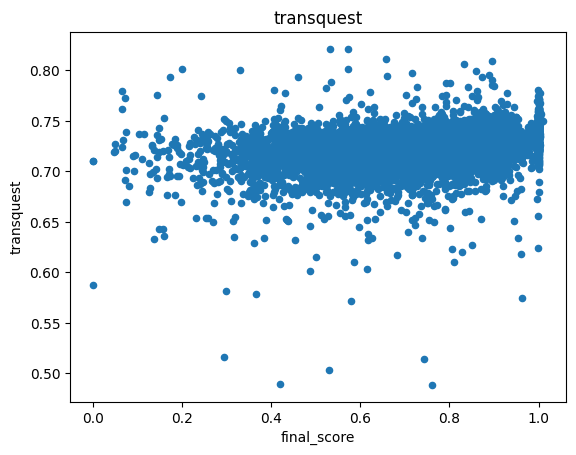

In [13]:
plot = tquest_df.plot.scatter(x="final_score", y="transquest", title="transquest")

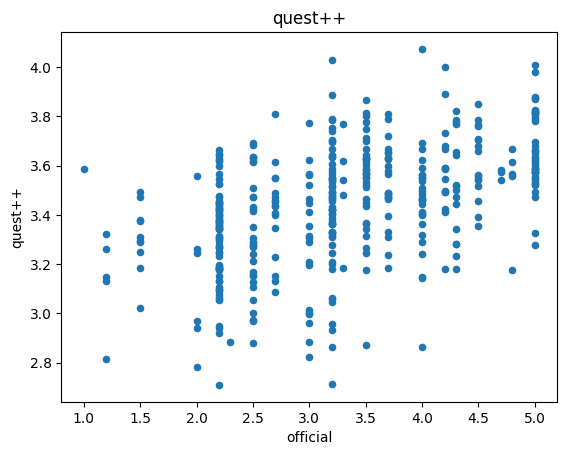

In [14]:
plot = pred.plot.scatter(x="official", y="quest++", title="quest++")

# NER : 

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
sentence = "the president Barack Obama was born in usa after 1950."
doc = nlp(sentence)

for ent in doc.ents:
    print(ent.text, ent.label_)

In [2]:
list_ent = {
    "PRODUCT" : "Adidas",
    "LOC" : "Himalayas",
    "DATE" : "1900",
    "TIME" : "2:30",
    "MONEY" : "$1",
    "PERSON" : "Joe",
    "ORGANIZATION" : "IBM",
    "GPE" : "Paris",
    "PERCENT" : "3%"
}

In [ ]:
spacy.explain("PRODUCT")

In [ ]:
sentence_orig = "Joe, who works for IBM, is planning a trip to the Himalayas to test his new Adidas hiking shoes that he bought for $1. The trip is scheduled for the year 1900, and he plans to start his hike at 2:30 pm. He hopes to see the beautiful mountain ranges and bodies of water in the region while also enjoying the local culture in Paris, where he will stopover for a few days. He also plans to invest some of his savings, which he hopes will earn him a return of 3%."
sentence = "Alex, who works for Apple, is planning a trip to the Alpin montains to test his new Nike hiking shoes that he bought for 25 euros. The trip is scheduled for next year 2000, and he plans to start his hike at 4am. He hopes to see the beautiful mountain ranges and bodies of water in the region while also enjoying the local culture in Munchen, where he will stopover for a few days. He also plans to invest some of his savings, which he hopes will earn him a return of 20 %."

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(sentence)

for ent in doc.ents:
    print(ent.text, ent.label_)